## Libraries

Do not import any additional libraries

In [ ]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F

## Download dataset and create a data loader
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this assignment, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO, MNIST ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the CIFAR10 dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#download training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#download test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define a CNN model with following layers: input > Conv > Pool > Conv > Pool > Linear > Output
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model = CNN().to(device) # for Adam optimizer
print(model)

model1 = CNN().to(device) # for SGD optimizer
print(model1)

model2 = CNN().to(device) # for RMSprop optimizer
print(model2)

model3 = CNN().to(device) # for Adagrad optimizer
print(model3)

Using cuda device
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Line

## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [ ]:
#negative log likelihood loss
loss_fn = nn.NLLLoss()

# use 'Adam', 'SGD', 'RMSprop', 'Adagrad' optimizers
optimizer = torch.optim.Adam(model.parameters())
optimizer1 = torch.optim.SGD(model1.parameters(),lr=0.001)
optimizer2 = torch.optim.RMSprop(model2.parameters(),lr=0.0001)
optimizer3 = torch.optim.Adagrad(model3.parameters())

## Training function

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

## Testing function

We also check the model's performance against the test dataset to ensure it is learning.



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

## Training process

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
# for Adam optimizer
epochs = 10
all_train_accuracies = []
all_test_accuracies = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model, loss_fn, optimizer)
    all_train_accuracies += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model, loss_fn)
    all_test_accuracies += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|█         | 1/10 [00:15<02:22, 15.83s/it]

Epoch 1:	 Train accuracy: 51.5%	 Avg train loss: 1.353292	 Test accuracy: 61.1%	 Avg test loss: 1.093919


 20%|██        | 2/10 [00:31<02:03, 15.49s/it]

Epoch 2:	 Train accuracy: 65.3%	 Avg train loss: 0.981668	 Test accuracy: 66.9%	 Avg test loss: 0.938794


 30%|███       | 3/10 [00:46<01:47, 15.40s/it]

Epoch 3:	 Train accuracy: 71.8%	 Avg train loss: 0.801403	 Test accuracy: 69.6%	 Avg test loss: 0.869945


 40%|████      | 4/10 [01:01<01:31, 15.33s/it]

Epoch 4:	 Train accuracy: 77.4%	 Avg train loss: 0.646619	 Test accuracy: 69.3%	 Avg test loss: 0.892433


 50%|█████     | 5/10 [01:17<01:17, 15.58s/it]

Epoch 5:	 Train accuracy: 82.2%	 Avg train loss: 0.512135	 Test accuracy: 71.6%	 Avg test loss: 0.877825


 60%|██████    | 6/10 [01:32<01:01, 15.42s/it]

Epoch 6:	 Train accuracy: 87.0%	 Avg train loss: 0.375298	 Test accuracy: 71.3%	 Avg test loss: 0.937661


 70%|███████   | 7/10 [01:47<00:45, 15.25s/it]

Epoch 7:	 Train accuracy: 91.2%	 Avg train loss: 0.258570	 Test accuracy: 70.9%	 Avg test loss: 1.062553


 80%|████████  | 8/10 [02:02<00:30, 15.22s/it]

Epoch 8:	 Train accuracy: 94.1%	 Avg train loss: 0.176105	 Test accuracy: 70.9%	 Avg test loss: 1.217898


 90%|█████████ | 9/10 [02:18<00:15, 15.46s/it]

Epoch 9:	 Train accuracy: 95.5%	 Avg train loss: 0.129692	 Test accuracy: 70.3%	 Avg test loss: 1.384095


100%|██████████| 10/10 [02:33<00:00, 15.36s/it]

Epoch 10:	 Train accuracy: 96.5%	 Avg train loss: 0.103402	 Test accuracy: 70.5%	 Avg test loss: 1.517097


In [ ]:
# for SGD optimizer
epochs = 10
all_train_accuracies_1 = []
all_test_accuracies_1 = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model1, loss_fn, optimizer1)
    all_train_accuracies_1 += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model1, loss_fn)
    all_test_accuracies_1 += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|█         | 1/10 [00:14<02:09, 14.40s/it]

Epoch 1:	 Train accuracy: 12.2%	 Avg train loss: 2.298891	 Test accuracy: 15.7%	 Avg test loss: 2.292746


 20%|██        | 2/10 [00:28<01:55, 14.49s/it]

Epoch 2:	 Train accuracy: 17.5%	 Avg train loss: 2.285232	 Test accuracy: 19.8%	 Avg test loss: 2.274650


 30%|███       | 3/10 [00:43<01:42, 14.59s/it]

Epoch 3:	 Train accuracy: 21.9%	 Avg train loss: 2.256911	 Test accuracy: 22.7%	 Avg test loss: 2.229595


 40%|████      | 4/10 [00:58<01:29, 14.86s/it]

Epoch 4:	 Train accuracy: 23.6%	 Avg train loss: 2.188177	 Test accuracy: 24.8%	 Avg test loss: 2.134627


 50%|█████     | 5/10 [01:13<01:13, 14.76s/it]

Epoch 5:	 Train accuracy: 25.4%	 Avg train loss: 2.098357	 Test accuracy: 27.5%	 Avg test loss: 2.053611


 60%|██████    | 6/10 [01:27<00:58, 14.64s/it]

Epoch 6:	 Train accuracy: 27.8%	 Avg train loss: 2.031389	 Test accuracy: 29.5%	 Avg test loss: 1.991046


 70%|███████   | 7/10 [01:42<00:43, 14.56s/it]

Epoch 7:	 Train accuracy: 30.4%	 Avg train loss: 1.968846	 Test accuracy: 32.6%	 Avg test loss: 1.925755


 80%|████████  | 8/10 [01:56<00:28, 14.49s/it]

Epoch 8:	 Train accuracy: 32.5%	 Avg train loss: 1.906814	 Test accuracy: 33.6%	 Avg test loss: 1.870114


 90%|█████████ | 9/10 [02:10<00:14, 14.41s/it]

Epoch 9:	 Train accuracy: 34.2%	 Avg train loss: 1.856370	 Test accuracy: 35.3%	 Avg test loss: 1.822608


100%|██████████| 10/10 [02:25<00:00, 14.59s/it]

Epoch 10:	 Train accuracy: 35.6%	 Avg train loss: 1.812905	 Test accuracy: 37.2%	 Avg test loss: 1.782018


In [ ]:
# for RMSprop optimizer
epochs = 10
all_train_accuracies_2 = []
all_test_accuracies_2 = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model2, loss_fn, optimizer2)
    all_train_accuracies_2 += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model2, loss_fn)
    all_test_accuracies_2 += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|█         | 1/10 [00:15<02:15, 15.03s/it]

Epoch 1:	 Train accuracy: 41.7%	 Avg train loss: 1.640114	 Test accuracy: 44.4%	 Avg test loss: 1.525195


 20%|██        | 2/10 [00:29<01:58, 14.77s/it]

Epoch 2:	 Train accuracy: 50.3%	 Avg train loss: 1.400908	 Test accuracy: 53.3%	 Avg test loss: 1.337075


 30%|███       | 3/10 [00:44<01:43, 14.74s/it]

Epoch 3:	 Train accuracy: 54.5%	 Avg train loss: 1.291007	 Test accuracy: 54.3%	 Avg test loss: 1.280342


 40%|████      | 4/10 [00:58<01:27, 14.65s/it]

Epoch 4:	 Train accuracy: 57.6%	 Avg train loss: 1.210256	 Test accuracy: 56.3%	 Avg test loss: 1.242979


 50%|█████     | 5/10 [01:13<01:14, 14.82s/it]

Epoch 5:	 Train accuracy: 60.0%	 Avg train loss: 1.143906	 Test accuracy: 54.4%	 Avg test loss: 1.253583


 60%|██████    | 6/10 [01:29<00:59, 14.97s/it]

Epoch 6:	 Train accuracy: 61.8%	 Avg train loss: 1.089258	 Test accuracy: 58.6%	 Avg test loss: 1.178522


 70%|███████   | 7/10 [01:43<00:44, 14.90s/it]

Epoch 7:	 Train accuracy: 63.6%	 Avg train loss: 1.039702	 Test accuracy: 60.1%	 Avg test loss: 1.129066


 80%|████████  | 8/10 [01:58<00:29, 14.82s/it]

Epoch 8:	 Train accuracy: 65.4%	 Avg train loss: 0.996034	 Test accuracy: 62.0%	 Avg test loss: 1.075151


 90%|█████████ | 9/10 [02:13<00:14, 14.75s/it]

Epoch 9:	 Train accuracy: 66.9%	 Avg train loss: 0.955664	 Test accuracy: 62.1%	 Avg test loss: 1.071141


100%|██████████| 10/10 [02:27<00:00, 14.79s/it]

Epoch 10:	 Train accuracy: 68.1%	 Avg train loss: 0.918133	 Test accuracy: 64.4%	 Avg test loss: 1.020080


In [ ]:
# for Adagrad optimizer
epochs = 10
all_train_accuracies_3 = []
all_test_accuracies_3 = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model3, loss_fn, optimizer3)
    all_train_accuracies_3 += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model3, loss_fn)
    all_test_accuracies_3 += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|█         | 1/10 [00:15<02:19, 15.52s/it]

Epoch 1:	 Train accuracy: 48.4%	 Avg train loss: 1.440345	 Test accuracy: 54.5%	 Avg test loss: 1.265522


 20%|██        | 2/10 [00:30<02:00, 15.01s/it]

Epoch 2:	 Train accuracy: 61.7%	 Avg train loss: 1.086743	 Test accuracy: 60.7%	 Avg test loss: 1.094064


 30%|███       | 3/10 [00:44<01:44, 14.91s/it]

Epoch 3:	 Train accuracy: 66.5%	 Avg train loss: 0.959664	 Test accuracy: 64.7%	 Avg test loss: 0.998196


 40%|████      | 4/10 [01:00<01:29, 14.98s/it]

Epoch 4:	 Train accuracy: 69.5%	 Avg train loss: 0.876815	 Test accuracy: 66.4%	 Avg test loss: 0.959225


 50%|█████     | 5/10 [01:14<01:14, 14.88s/it]

Epoch 5:	 Train accuracy: 71.8%	 Avg train loss: 0.811351	 Test accuracy: 63.6%	 Avg test loss: 1.031265


 60%|██████    | 6/10 [01:30<01:00, 15.06s/it]

Epoch 6:	 Train accuracy: 73.9%	 Avg train loss: 0.756019	 Test accuracy: 66.8%	 Avg test loss: 0.946758


 70%|███████   | 7/10 [01:44<00:44, 14.98s/it]

Epoch 7:	 Train accuracy: 75.4%	 Avg train loss: 0.710392	 Test accuracy: 68.3%	 Avg test loss: 0.916490


 80%|████████  | 8/10 [01:59<00:29, 14.91s/it]

Epoch 8:	 Train accuracy: 77.0%	 Avg train loss: 0.666919	 Test accuracy: 68.9%	 Avg test loss: 0.918267


 90%|█████████ | 9/10 [02:14<00:14, 14.83s/it]

Epoch 9:	 Train accuracy: 78.6%	 Avg train loss: 0.625931	 Test accuracy: 69.9%	 Avg test loss: 0.881568


100%|██████████| 10/10 [02:29<00:00, 14.90s/it]

Epoch 10:	 Train accuracy: 79.9%	 Avg train loss: 0.589259	 Test accuracy: 70.0%	 Avg test loss: 0.897387


## Plot Results

Display the training and testing accuracy as a function of the number of epochs



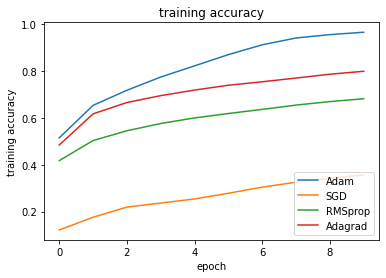

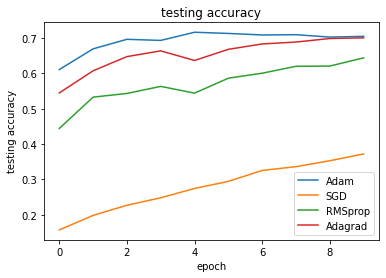

In [ ]:
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_1)
plt.plot(all_train_accuracies_2)
plt.plot(all_train_accuracies_3)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD', 'RMSprop', 'Adagrad'], loc='lower right')
plt.show()

plt.plot(all_test_accuracies)
plt.plot(all_test_accuracies_1)
plt.plot(all_test_accuracies_2)
plt.plot(all_test_accuracies_3)
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD', 'RMSprop', 'Adagrad'], loc='lower right')
plt.show()


Explanation:

* As we can see from the training and testing accuracy plots, Adam and Adagrad optimizer based trained models are giving us the highest test accuracy levels after certain number of epochs. RMSprop gives little less test accuracy compared to the previous two. and SGD is giving us very less test accuracy level. We relatively get same accuracy comparison conclusion from the train dataset.
* Main reason behind these differences in the accuracy levels between optimizers are their formula and information each use for parameter update.
* AdaGrad is improved version of SGD and it includes second-order information as well while updating parameters, and this provides adaptive learning rates for each parameter. This explains why we get higher train and test accuracy with the AdaGrad than SGD.
*Adam on the other hand also use gradients' first and second uncentred moments in its update rule. So, this momentum (running average of the gradient) further improves learning of the model parameters and that's why it gives even higher accuracy levels compared to AdaGrad.
* RMSprop is similar to Adam but it does not use momentum of gradient, and this explains why RMSprop is slower and less accurate compared to Adam in optimizing the model parameters, and as a result it gives less test accuracy compared to Adam based trained model.
* Also the learning rate and momentum values we select while training the model also governs our model training performance. So, it is possible that if we train SGD based model longer (i.e. for more epochs) or use higher learning rate then we may get somewhat comparable train and test accuracy levels also with the SGD optimizer based model.

